## COMP411/511  HW2
### Deadline: 01 Dec, 23:59

Make sure that your PyTorch version is at least 2.4

In addition to `numpy` and `matplotlib`, you should also install the `scikit-learn` package:

```pip install scikit-learn```

(Or you can use Google Colab which has everything pre-installed)




The instructions are given as comments throughout the code.\
The parts of the code that you need to implement are inside the blocks specified as
```
# == Your code here == #
# ==================== #
```
Your task is to fill them in with the correct code. Do not change any other code.\
You also have some questions to answer. They are marked with "QA" as markdown cells.

Parts:
1. L1/L2 Regularization      (30 Points)
2. Dropout Regularization (30 Points)
3. Optimizers   (10 Points)
4. Finding best settings  (30 Points)

Total: 100 points

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler


import torchvision.datasets as dset
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# download CIFAR dataset
NUM_TRAIN = 40000

transform = v2.Compose([v2.ToTensor(), v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_train = dset.CIFAR10('./datasets', train=True, download=True, transform=transform)
cifar_val = dset.CIFAR10('./datasets', train=False, download=True, transform=transform)
loader_train = DataLoader(cifar_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar_val, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataloader_iter = iter(loader_train)  # Create an iterator from the DataLoader

# Get the next batch
batch = next(dataloader_iter)
images, labels = batch  # Unpack the images and labels
images.shape


torch.Size([64, 3, 32, 32])

In [4]:
# use GPU if available, otherwise use CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
32*32*3

3072

In [6]:
# Create a single layer neural network
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

# L1/L2 Regularization

In [7]:
# We are going to train two single layer models with L2 regularizations
# In the first model, we will exploit PyTorch optimizer to apply L2 regularization without changing the loss function explicitly
# In the second model, we will apply L2 regularization manually by adding the regularization term to the loss function
# We will compare the weights of the two models after training to make sure that the two implementations are the same
# In order to do so we need to create two identical models

In [8]:
# First create a single layer model
# We will use this one to train using PyTorch's L2 regularization
# == Your code here == # (2 Pts)
model = SingleLayerNN(3072, 10)
# ==================== #
model.to(DEVICE)

# Now create a copy of the model
# We will use this one to train using manual L2 regularization
# We want to make sure that the two models are identical
# However since the weights are initialized randomly, if we just create a new instance of SingleLayerNN, their weights will not be identical
# You need to make sure that the weights of the two models are the same
# HINT: You can copy the model (How?), or you can make sure that the models are initialized with the same random seed
# == Your code here == # (2 Pts)
model_l2 = copy.deepcopy(model)
# ==================== #

# We will also train a model with manual L1 regularization by manually adding the regularization term to the loss function
# Again create a copy of the original model
# == Your code here == # (2 Pts)
model_l1 = copy.deepcopy(model)
# ==================== #

assert torch.equal(model.fc.weight, model_l2.fc.weight), 'model and model_l2 weights should be the same'
assert torch.equal(model.fc.weight, model_l1.fc.weight), 'model and model_l1 weights should be the same'

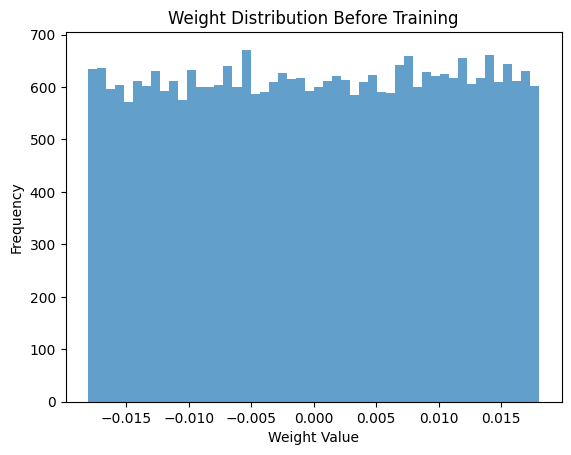

In [9]:
# Visualize distribution of the weights of the fully connected layer before training
# == Your code here == # (2 Pts)
weights = model.fc.weight.detach().cpu().numpy()  # Extract weights from the fully connected layer
weights_flat = weights.flatten()  # Flatten the weights for easier visualization

plt.hist(weights_flat, bins=50, alpha=0.7)
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
# ==================== #
plt.title('Weight Distribution Before Training')
plt.show()


### QA (2 Pts)
Q: What is the distribution of the weights exactly?
(Hint: Check how PyTorch initializes linear layes)

A: The weights are initialized with kaiming initialization by defaul in Pytorch. The weights are initialized with uniform distribution in the interval<br> (-1 / math.sqrt(fan_in), 1 / math.sqrt(fan_in))

In [10]:
# (10 Pts)
def train_loop(dataloader, model, loss_fn, optimizer, reg, w_reg):
    # reg defines the type of regularization, either 'l1' or 'l2' or None
    # w_reg is the regularization weight
    model.train()
    for x, y in dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        if reg == 'l2':

            # == Your code here == #
            l2_norm = sum(param.pow(2).sum() for param in model.parameters())
            loss += (w_reg/2) * l2_norm
            # ==================== #
        elif reg == 'l1':

            # == Your code here == #
            l1_norm = sum(param.abs().sum() for param in model.parameters())
            loss += w_reg * l1_norm
            # ==================== #
        elif reg is not None:
            raise ValueError('Invalid regularization type')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def eval_loop(dataloader, model, loss_fn, reg=None, w_reg=None):
    # reg defines the type of regularization, either 'l1' or 'l2' or None
    # w_reg is the regularization weight
    # modify this function the same as the train_loop
    model.eval()
    num_correct = 0
    num_samples = 0
    total_loss = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            if reg == 'l2':
                pass
                # == Your code here == #

                # ==================== #
            elif reg == 'l1':
                pass
                # == Your code here == #

                # ==================== #
            elif reg is not None:
                raise ValueError('Invalid regularization type')
            total_loss += loss.item()
            num_correct += (pred.argmax(1) == y).sum().item()
            num_samples += pred.shape[0]

    acc = 100*(num_correct / num_samples)
    total_loss /= len(dataloader)
    return acc, total_loss


def run(loader_train, loader_val, model, loss_fn, optimizer, num_epochs=1, reg=None, w_reg=None):
    torch.manual_seed(0)
    np.random.seed(0)
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    for i in range(num_epochs):
        train_loop(loader_train, model, loss_fn, optimizer, reg, w_reg)
        train_acc, train_loss = eval_loop(loader_train, model, loss_fn, reg, w_reg)
        val_acc, val_loss = eval_loop(loader_val, model, loss_fn, reg, w_reg)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {i+1}/{num_epochs}, Train Acc: {train_acc:.4f}%, Val Acc: {val_acc:.4f}%')
    print('-'*50)
    return train_accs, val_accs, train_losses, val_losses


In [11]:
# Define hyperparameters
learning_rate = 1e-2
w_reg = 1e-3 # regularization weight
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

In [12]:
# Train the model with PyTorch Optimizer's L2 regularization
# create the SGD optimizer which applies L2 regularization (Hint: check the parameters of the SGD optimizer)
print("Training Model with PyTorch Optimizer's L2 Regularization")
# == Your code here == # (2 Pts)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=w_reg)
# ==================== #
train_accs, val_accs, train_losses, val_losses = run(loader_train, loader_val, model, loss_fn, optimizer, num_epochs=num_epochs)

Training Model with PyTorch Optimizer's L2 Regularization
Epoch 1/1, Train Acc: 39.8600%, Val Acc: 38.4700%
--------------------------------------------------


In [13]:
# Now finish the implementation of train_loop and eval_loop functions to include L2 regularization and then run this cell
print("Training Model with Manual L2 Regularization")
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=learning_rate)
train_accs_l2, val_accs_l2, train_losses_l2, val_losses_l2 = run(loader_train, loader_val, model_l2, loss_fn, optimizer_l2, num_epochs=num_epochs, reg='l2', w_reg=w_reg)

Training Model with Manual L2 Regularization
Epoch 1/1, Train Acc: 39.8600%, Val Acc: 38.4700%
--------------------------------------------------


In [14]:
# Train/Val accuracies for two versions must be exactly the same.
# More importantly, the weights of the model after the training should be the same too:
assert val_accs_l2 == val_accs and train_accs_l2 == train_accs, 'Manual L2 regularization results should match PyTorch Optimizer L2 regularization results'
assert torch.allclose(model_l2.fc.weight, model.fc.weight) and torch.allclose(model_l2.fc.bias, model.fc.bias), "Manual L2 implementation yields different reuslts from PyTorch's L2 implementation"

In [15]:
print(f"L2 Regularization with PyTorch: Train Losses: {train_losses}, Val Losses: {val_losses}")
print(f"L2 Regularization Manually:     Train Losses: {train_losses_l2}, Val Losses: {val_losses_l2}")

L2 Regularization with PyTorch: Train Losses: [1.7707115539550782], Val Losses: [1.789253975935043]
L2 Regularization Manually:     Train Losses: [1.7707115503311157], Val Losses: [1.7892539736571584]


### QA (2 Pts)
Q: Although we verified that the the weights and train/val accuracies for our L2 regularization and PyTorch's implementation are exactly the same, however we can see that the train/val losses are not the same for these two versions. Why? (Hint: You can check the documentation/source code for how PyTorch implements L2 regularization)

A:

In [16]:
# Now finish the implementation of train_loop and eval_loop functions to include L1 regularization and then run this cell
print("Training Model with Manual L1 Regularization")
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=learning_rate)
train_accs_l1, val_accs_l1, train_losses_l1, val_losses_l1 = run(loader_train, loader_val, model_l1, loss_fn, optimizer_l1, num_epochs=num_epochs, reg='l1', w_reg=w_reg)

Training Model with Manual L1 Regularization
Epoch 1/1, Train Acc: 39.4400%, Val Acc: 38.4400%
--------------------------------------------------


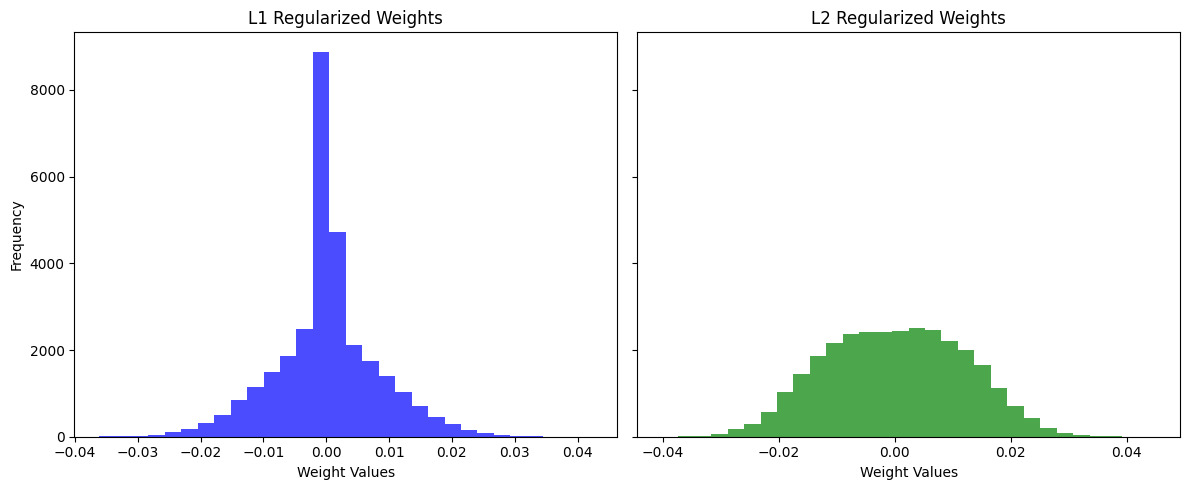

In [17]:
# Visualize distribution of the weights of the fully connected layer after training
# Visualize the weights for L1 and L2 regularized models as two histograms side by side using subplots
# == Your code here == # (4 Pts)
# Extract weights of the fully connected layer
fc_weights_l1 = model_l1.fc.weight.data.cpu().numpy().flatten()
fc_weights_l2 = model_l2.fc.weight.data.cpu().numpy().flatten()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# L1 Regularized Model Histogram
axes[0].hist(fc_weights_l1, bins=30, color='blue', alpha=0.7)
axes[0].set_title('L1 Regularized Weights')
axes[0].set_xlabel('Weight Values')
axes[0].set_ylabel('Frequency')

# L2 Regularized Model Histogram
axes[1].hist(fc_weights_l2, bins=30, color='green', alpha=0.7)
axes[1].set_title('L2 Regularized Weights')
axes[1].set_xlabel('Weight Values')

# Adjust layout and show the plot
plt.tight_layout()
# ==================== #
plt.show()


### QA (2 Pts)
Q: How does L1 regularization affect the weights compared to L2 regularizaiton? Discuss and explain the differences.

A: L2 prefers solutions/weights that take into account every feature, L1 prefers to rely heavily on certain key features and discard others. L2 penalizes the sum of squares, making sure that no weight is very large. L1 can give some weights that are very large, but in turn the other weight are minimized to be very small.

# Dropout

In [18]:
# Implement a Dropout Layer from scratch (You cannot use nn.Dropout)
# p is the probability of setting a neuron to zero
# Pay attention to the different behaviour of the layer during training and evaluation
# Specifically:
# during training the output should be scaled by 1/(1-p) to ensure that the expected value of the output remains the same
# during evaluation the output should be the same as the input
# Remember that you must NOT use for loops for zeroing out the neurons, instead you should create a mask and apply it to the input tensor

# 15 Pts
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        # == Your code here == #
        self.p = p
        # ==================== #
    def forward(self, x):
        if self.training:

            # == Your code here == #
            mask = (torch.rand_like(x) > self.p).float()
            return mask * x / (1 - self.p)
        else:
            # == Your code here == #
            return x
            # ==================== #

In [19]:
# Implement an alternative Dropout Layer as follows:
# p is always equal to 0.5
# at first iteration, randomly set half of the neurons to zero
# at the second iteration, set the other half of the neurons to zero (neurons that were not set to zero in the first iteration should be set to zero)
# at the third iteration, randomly set half of the neurons to zero
# at the fourth iteration, set the other half of the neurons to zero (neurons that were not set to zero in the first iteration should be set to zero)
# and so on
# Don't forget that the scaling should be the same as CustomDropout above
# You must NOT use for loops for zeroing out the neurons, instead you should create a mask and apply it to the input tensor

# 15 Pts
class AlternatingDropout(nn.Module):
    def __init__(self):
        super().__init__()
        # == Your code here == #
        self.iteration = 0
        self.mask_a = None  # First mask
        self.mask_b = None  # Second mask
        # ==================== #
    def forward(self, x):
        if self.training:
            # == Your code here == #
            if self.mask_a is None or self.mask_a.shape != x.shape or self.iteration % 2 == 0:
                self.mask_a = (torch.rand_like(x) > 0.5)

                # Second mask (drop the complementary neurons)
                self.mask_b = ~self.mask_a


            if self.iteration % 2 == 0:
                mask = self.mask_a
            else:
                mask = self.mask_b

            self.iteration += 1

            return x * mask.float() * 2
            # ==================== #
        else:

            # == Your code here == #
            return x
            # ==================== #

In [20]:
# Do not modify this cell
def test_dropout():
    size = (1000,1000)
    x = torch.ones(size)
    dropout = CustomDropout(p=0.2)
    dropout.train()
    torch.manual_seed(0)
    np.random.seed(0)
    y = dropout(x)
    p = (y==0).sum()/y.numel()
    assert 0.18 < p < 0.22, 'Custom Dropout is not working'
    assert (y.unique().sort()[0] == torch.tensor([0., 1.25]).to(y.device)).all(), 'Custom Dropout is not working'
    dropout.eval()
    y = dropout(x)
    assert torch.equal(x, y), 'Custom Dropout is not working'

    x = torch.ones(size)
    dropout = CustomDropout(p=0.5)
    torch.manual_seed(0)
    np.random.seed(0)
    dropout.train()
    y1 = dropout(x)
    y2 = dropout(x)

    alternating = AlternatingDropout()
    alternating.train()
    torch.manual_seed(0)
    np.random.seed(0)
    a1 = alternating(x)
    a2 = alternating(x)
    a3 = alternating(x)
    a4 = alternating(x)

    assert torch.equal(a1, 2-a2), 'Alternating Dropout is not working'
    assert torch.equal(a3, 2-a4), 'Alternating Dropout is not working'
    assert torch.equal(a1, y1) and torch.equal(a3, y2), 'Alternating Dropout is not working'
    alternating.eval()
    a5 = alternating(x)
    assert torch.equal(a5, x), 'Alternating Dropout is not working'

    print('✓ Dropout test cases passed successfully!')


In [21]:
# Run this cell to test your implementation of CustomDropout and AlternatingDropout
test_dropout()

✓ Dropout test cases passed successfully!


# Optimizers

In [22]:
# The goal of this part is to visualize the trajectory of the parameters during training using SGD and Adam optimizers
# We will use a toy model with only two parameters and a simple loss function
# The code below tracks the parameters during training and then visualizes the trajectory of the parameters
# Your task is to create the optimizers correctly and then update the parameters using the optimizers correctly

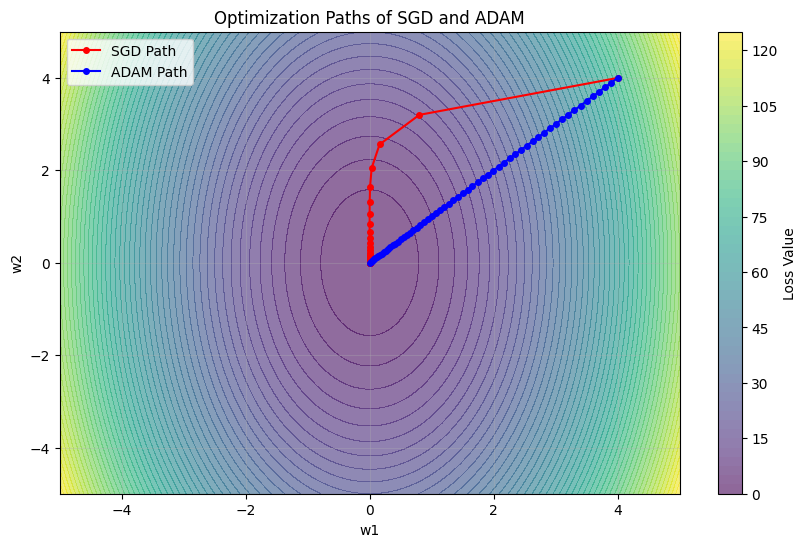

In [23]:
def loss_function(x, y):
    return (4*x ** 2 + y ** 2)


# Initialize parameters
x_sgd, y_sgd = torch.tensor(4.0, requires_grad=True), torch.tensor(4.0, requires_grad=True)
x_adam, y_adam = torch.tensor(4.0, requires_grad=True), torch.tensor(4.0, requires_grad=True)

# Optimizers
lr = 0.1

# == Your code here == # (2 Pts)
sgd_optimizer = torch.optim.SGD(params=[x_sgd, y_sgd], lr=lr)
adam_optimizer = torch.optim.Adam(params=[x_adam, y_adam], lr=lr)
# ==================== #

# Store paths for visualization
path_sgd = [(x_sgd.item(), y_sgd.item())]
path_adam = [(x_adam.item(), y_adam.item())]

# Optimization loop
steps = 60
for _ in range(steps):
    # SGD Step
    # == Your code here == # (3 Pts)
    loss = loss_function(x_sgd, y_sgd)
    loss.backward()
    sgd_optimizer.step()
    sgd_optimizer.zero_grad()

    # ==================== #
    path_sgd.append((x_sgd.item(), y_sgd.item()))

    # ADAM Step
    # == Your code here == # (3 Pts)
    loss = loss_function(x_adam, y_adam)
    loss.backward()
    adam_optimizer.step()
    adam_optimizer.zero_grad()
    # ==================== #
    path_adam.append((x_adam.item(), y_adam.item()))

# Visualization
path_sgd = np.array(path_sgd)
path_adam = np.array(path_adam)

x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = loss_function(x, y)

plt.figure(figsize=(10, 6))
plt.contourf(x, y, z, levels=50, cmap='viridis', alpha=0.6)
plt.colorbar(label='Loss Value')
plt.plot(path_sgd[:, 0], path_sgd[:, 1], 'r-o', label='SGD Path', markersize=4)
plt.plot(path_adam[:, 0], path_adam[:, 1], 'b-o', label='ADAM Path', markersize=4)
plt.legend()
plt.title("Optimization Paths of SGD and ADAM")
plt.xlabel("w1")
plt.ylabel("w2")
plt.grid(alpha=0.3)
plt.show()

### QA (2 Pts)
Q: Explain the results and discuss how each optimizer influence the trajectory of parameters during training

A: By conservatively updating the weights with larger gradients, Adam reaches the optimum with a smoother path and avoids the large initial update performed by sgd, while sgd starts with noisy updates. Also, Adam uses bias correction at the beginning of the training. Adam makes sure there are no oscillations and noise.

# Finding Best Settings

In [24]:
# Now define models of your choice and train them on CIFAR10 with different hyperparameters, regularization settings, and optimizers
# And find a model that performs best on the validation set
# You should experiment with different hyperparameters, optimizers, learning rates, regularization types and weights, number of epochs, etc...
# You should show that you have tried different configurations (You can create for loops to try different hyperparameters)
# Your model should achieve at least 50% accuracy on the validation set
# You are free to create as many cells as you want
# You can use any of the training techniques you have learned in the course


In [25]:
class BestNetwork(torch.nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=False):
        """
        Args:
            in_dim (int): Input dimension
            hidden_dims (list of int): List of hidden layer dimensions
            out_dim (int): Output dimension
            dropout (bool): Whether to use dropout
        """
        super(BestNetwork, self).__init__()

        layers = []
        current_dim = in_dim
        for hid_dim in hidden_dims:
            fc = nn.Linear(current_dim, hid_dim)
            nn.init.constant_(fc.bias, 0.01)
            layers.append(fc)
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=0.5))
            current_dim = hid_dim
        self.hidden_layers = nn.ModuleList(layers)

        # Output layer
        self.fc_out = nn.Linear(current_dim, out_dim)
        nn.init.constant_(self.fc_out.bias, 0.01)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.fc_out(x)
        return x

In [26]:
hyperparams = [
    {'lr': 0.001, 'epochs': 30, 'weight_decay': 0.001, 'hidden_dims': [2048], 'dropout': False},
    {'lr': 0.001, 'epochs': 30, 'weight_decay': 0.001, 'hidden_dims': [1024, 512], 'dropout': False},
    {'lr': 0.001, 'epochs': 30, 'weight_decay': 0, 'hidden_dims': [1024, 512], 'dropout': True},
    {'lr': 0.001, 'epochs': 50, 'weight_decay': 0.001, 'hidden_dims': [2048, 1024, 512], 'dropout': True},
]

In [27]:
results = []
models = []

for i, params in enumerate(hyperparams):
    print(f"\nRunning experiment {i+1} with params: {params}")

    model = BestNetwork(in_dim=3072, hidden_dims=params['hidden_dims'], out_dim=10, dropout=params['dropout'])
    model = nn.DataParallel(model)
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    train_accs, val_accs, train_losses, val_losses = run(
        loader_train, loader_val, model, nn.CrossEntropyLoss(), optimizer,
        num_epochs=params['epochs']
    )

    # Evaluate and store results
    final_val_acc = eval_loop(loader_val, model, nn.CrossEntropyLoss())[0]
    print(f"Final Validation Accuracy for experiment {i+1}: {final_val_acc:.2f}%")

    # Append results
    results.append({
        'params': params,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_acc': final_val_acc
    })
    models.append(model)


Running experiment 1 with params: {'lr': 0.001, 'epochs': 30, 'weight_decay': 0.001, 'hidden_dims': [2048], 'dropout': False}
Epoch 1/30, Train Acc: 44.8600%, Val Acc: 42.5600%
Epoch 2/30, Train Acc: 47.2800%, Val Acc: 45.3300%
Epoch 3/30, Train Acc: 48.0875%, Val Acc: 45.9000%
Epoch 4/30, Train Acc: 49.1575%, Val Acc: 45.6800%
Epoch 5/30, Train Acc: 49.7050%, Val Acc: 45.3900%
Epoch 6/30, Train Acc: 51.3625%, Val Acc: 45.9100%
Epoch 7/30, Train Acc: 52.7200%, Val Acc: 48.0700%
Epoch 8/30, Train Acc: 53.6350%, Val Acc: 47.1300%
Epoch 9/30, Train Acc: 54.6225%, Val Acc: 47.5500%
Epoch 10/30, Train Acc: 56.3650%, Val Acc: 49.6500%
Epoch 11/30, Train Acc: 53.5050%, Val Acc: 47.2500%
Epoch 12/30, Train Acc: 56.0175%, Val Acc: 48.4200%
Epoch 13/30, Train Acc: 55.6850%, Val Acc: 48.0300%
Epoch 14/30, Train Acc: 56.9575%, Val Acc: 48.7500%
Epoch 15/30, Train Acc: 56.2400%, Val Acc: 47.9600%
Epoch 16/30, Train Acc: 54.5950%, Val Acc: 46.6800%
Epoch 17/30, Train Acc: 55.9050%, Val Acc: 47.0400

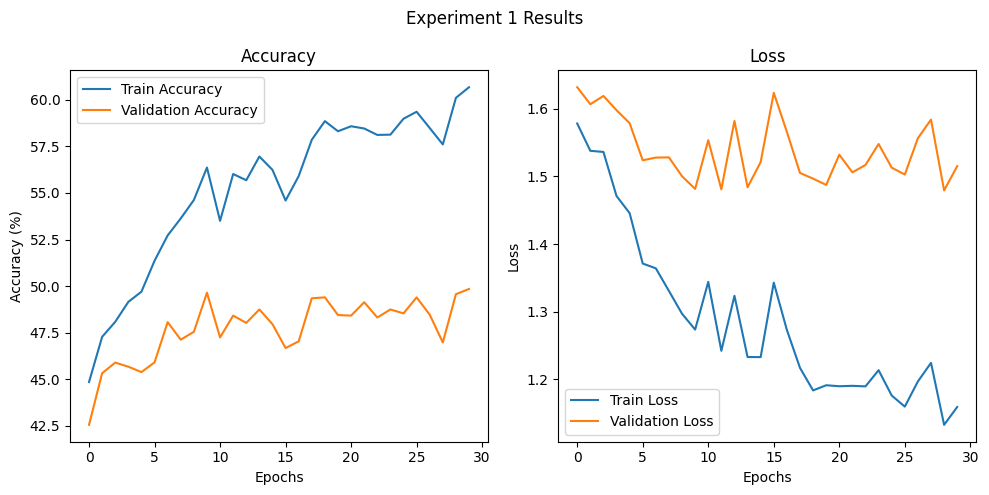

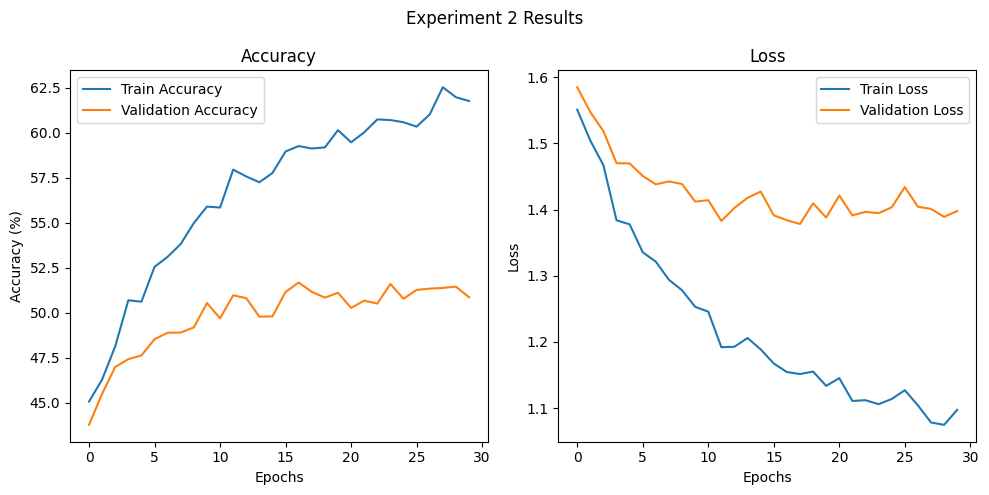

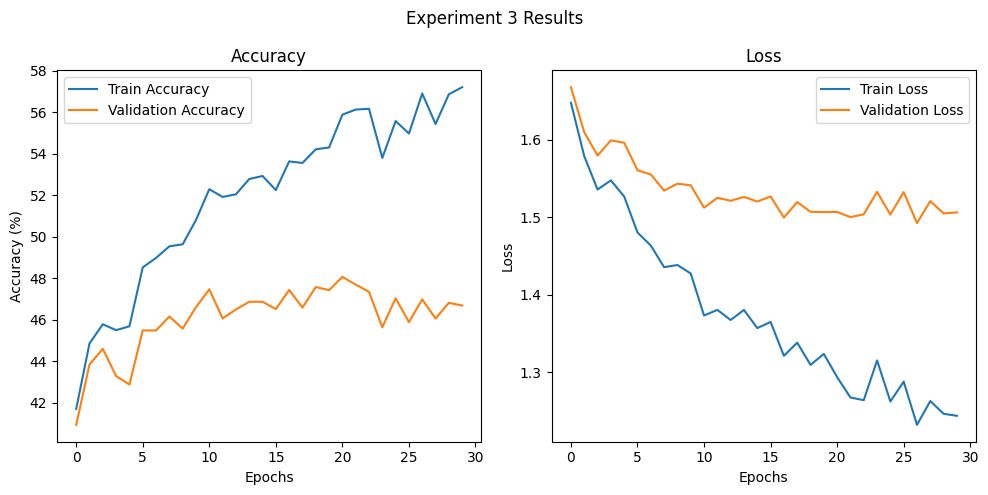

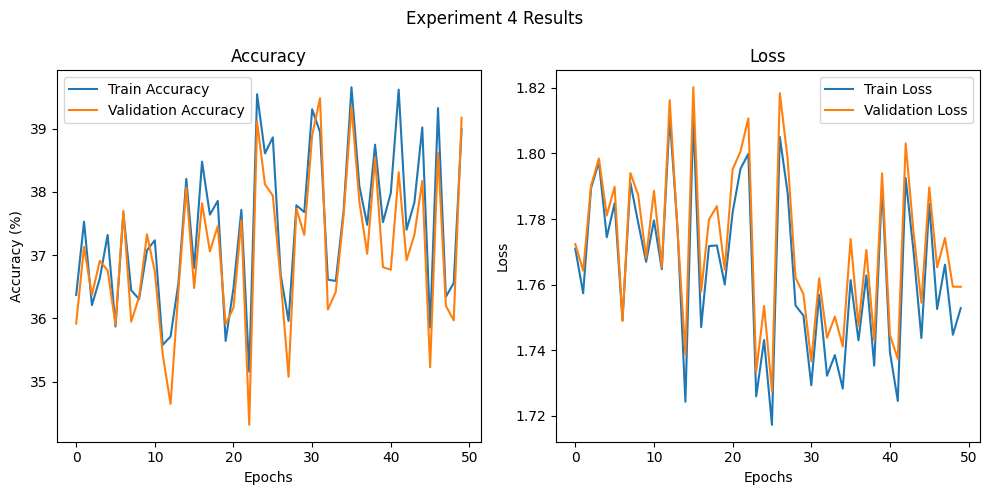

In [28]:
for i, result in enumerate(results):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Experiment {i+1} Results")

    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(result['train_accs'], label="Train Accuracy")
    plt.plot(result['val_accs'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy")
    plt.legend()

    # Training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(result['train_losses'], label="Train Loss")
    plt.plot(result['val_losses'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
# set the best model, best optimizer, and best learning rate according to the best configuration you have found

# === Your Code Here === (28 Pts)
best_model = models[1]
best_lr = 0.001
best_opt = torch.optim.Adam(best_model.parameters(), lr=best_lr, weight_decay = 0.001)
# ==================== #
best_val_acc = eval_loop(loader_val, best_model, loss_fn)[0]
print(f"Achieved validation accuracy: {best_val_acc:.2f}%, with learning rate: {best_lr}, and optimizer: {best_opt}")


Achieved validation accuracy: 50.86%, with learning rate: 0.001, and optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)


In [30]:
# Now we will add gaussian noise to the validation set and test the model on it

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified


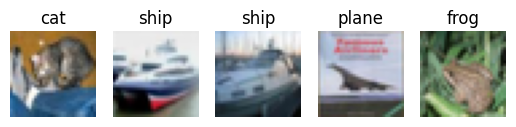

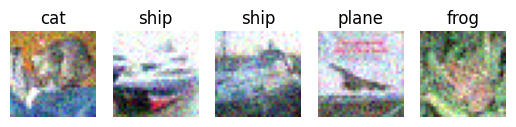

In [31]:
# The code below creates the CIFAR10 dataset with added gaussian noise
# It then visualizes the first 5 images in the original validation set and the noisy validation set
def denormalize_img(img):
    img = img / 2 + 0.5
    return img

transform_noise = v2.Compose([v2.ToTensor(), v2.GaussianNoise(0.1, 0.1), v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_val_noise = dset.CIFAR10('./datasets', train=False, download=True, transform=transform_noise)
loader_val_noise = DataLoader(cifar_val_noise, batch_size=64)

fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(denormalize_img(cifar_val[i][0].permute(1,2,0)))
    axes[i].set_title(classes[cifar_val[i][1]])
    axes[i].axis('off')


fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(denormalize_img(cifar_val_noise[i][0].permute(1,2,0)))
    axes[i].set_title(classes[cifar_val[i][1]])
    axes[i].axis('off')


In [32]:
# Evaluate the best model on the noisy validation set
print('Model performance on the validation set with noise:', eval_loop(loader_val_noise, best_model, loss_fn)[0])



Model performance on the validation set with noise: 48.339999999999996


### QA (2 Pts)
Q: How does the result change? Briefly explain why.

A: The accuracy of the model decreases on noisy validation set. The model learns the importance of pixels and features as their combination, adding random noise to the input distorts the features that the model relies on. To overcome this, we can train the model on noisy data.